In [1]:
import matplotlib

In [2]:
matplotlib.use('Agg')

In [3]:
%matplotlib qt

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np

In [6]:
import os

In [7]:
import SimpleITK as sitk

In [8]:
from os.path import expanduser, join

In [9]:
from scipy.spatial.distance import euclidean

In [10]:
os.chdir(join(expanduser('~'), 'Medical Imaging'))

In [11]:
import liversegmentation

---

# Read in DICOM images

In [12]:
sliceNum = 42

In [13]:
dicomPath = join(expanduser('~'), 'Documents', 'SlicerDICOMDatabase', 'TCIALocal', '0', 'images', '')
reader = sitk.ImageSeriesReader()
seriesIDread = reader.GetGDCMSeriesIDs(dicomPath)[1]
dicomFilenames = reader.GetGDCMSeriesFileNames(dicomPath, seriesIDread)
reader.SetFileNames(dicomFilenames)
imgSeries = reader.Execute()
imgSlice = imgSeries[:,:,sliceNum]

Note that the TCGA-BC-4073 patient has 2 series of images (series 9 & 10). The series IDs are:

In [10]:
reader.GetGDCMSeriesIDs(dicomPath)

('1.3.6.1.4.1.14519.5.2.1.8421.4008.138804327531308458796105931925',
 '1.3.6.1.4.1.14519.5.2.1.8421.4008.409273914557307131521893097931')

By comparing images between OsiriX and plots of the SimpleITK images, the 2<sup>nd</sup> tuple element corresponds to series 9. 

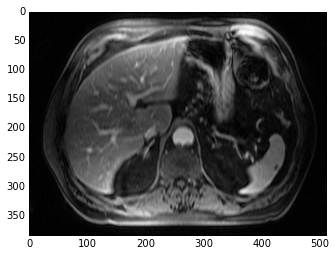

In [13]:
liversegmentation.sitk_show(imgSlice)

Cast original slice to unsigned 8-bit integer so that segmentations can be overlaid on top

In [14]:
imgSliceUInt8 = sitk.Cast(sitk.RescaleIntensity(imgSlice), sitk.sitkUInt8)

# Filtering

## Curvature anisotropic diffusion

In [15]:
anisoParams = (0.06, 9.0, 5)

In [16]:
imgFilter = liversegmentation.anisotropic_diffusion(imgSlice, *anisoParams)

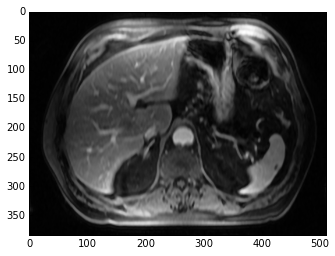

In [16]:
liversegmentation.sitk_show(imgFilter)

## Median filter

In [14]:
med = sitk.MedianImageFilter()
med.SetRadius(3)
imgFilter = med.Execute(imgSlice)

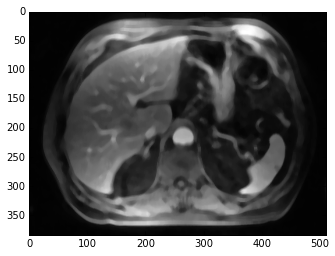

In [17]:
liversegmentation.sitk_show(imgFilter)

# Edge potential

## Gradient magnitude recursive Gaussian

In [221]:
#sigma = 3.0
sigma = 1.0
imgGauss = liversegmentation.gradient_magnitude(imgFilter, sigma)

In [168]:
liversegmentation.sitk_show(imgGauss)

# Feature Image

## Sigmoid mapping

In [239]:
#K1, K2 = 20.0, 6.0
#K1, K2 = 14.0, 4.0
K1, K2 = 8.0, 2.0

In [45]:
imgSigmoid = liversegmentation.sigmoid_filter(imgGauss, K1, K2)

In [241]:
liversegmentation.sitk_show(imgSigmoid)

# Input level set

Create 2 lists, one to hold the seed coordinates and the other for the radii. The radius in the 1<sup>st</sup> index corresponds to the 1<sup>st</sup> index, and so on. 

In [20]:
coords = [(118, 286), (135, 254), (202, 75), (169, 89), (145, 209), (142, 147), (252, 58), (205, 119)]

In [21]:
radii = [10, 10, 10, 10, 10, 10, 5, 5]

In [22]:
seed2radius = {tuple(reversed(p[0])): p[1] for p in zip(coords, radii)}

In [23]:
initImg = liversegmentation.input_level_set(imgSigmoid, seed2radius)

In [63]:
liversegmentation.sitk_show(initImg)

Creating new level set from segmentation of downsampled image.

First convert the segmentation result into a workable format:

In [53]:
binaryThresh = sitk.BinaryThresholdImageFilter()
binaryThresh.SetLowerThreshold(-2.3438)
binaryThresh.SetUpperThreshold(0.0)
binaryThresh.SetInsideValue(1)
binaryThresh.SetOutsideValue(0)
binaryImg = binaryThresh.Execute(imgGac2)

In [228]:
liversegmentation.sitk_show(binaryImg)

Add in new seeds:

In [37]:
coords2 = [(235, 108), (199, 188), (120, 113), (96, 140)]
radii2 = [5, 5, 5, 5]

In [38]:
seed2radius2 = {tuple(reversed(p[0])): p[1] for p in zip(coords2, radii2)}

Now create new level set image:

In [39]:
X_1 = sitk.GetArrayFromImage(binaryImg)

# create a 2nd seed matrix from the 2nd set of coordinates
setupImg = sitk.Image(imgSigmoid.GetSize()[0], imgSigmoid.GetSize()[1], sitk.sitkUInt8)
X_2 = sitk.GetArrayFromImage(setupImg)
for i in range(X_2.shape[0]):
    for j in range(X_2.shape[1]):
        for s in seed2radius2.keys():
            if euclidean((i,j), s) <= seed2radius2[s]:
                X_2[i,j] = 1

X = X_1.astype(bool) + X_2.astype(bool)
initImg2 = sitk.Cast(sitk.GetImageFromArray(X.astype(int)), imgSigmoid.GetPixelIDValue()) * -1 + 0.5
initImg2.SetSpacing(imgSigmoid.GetSpacing())
initImg2.SetOrigin(imgSigmoid.GetOrigin())
initImg2.SetDirection(imgSigmoid.GetDirection())

In [113]:
liversegmentation.sitk_show(initImg2)

Add in a 3<sup>rd</sup> set of seeds:

In [46]:
coords3 = [(225, 177), (246, 114), (83, 229), (78, 208), (82, 183), (238, 126)]
radii3 = [5, 10, 5, 5, 5, 15]

In [47]:
seed2radius3 = {tuple(reversed(p[0])): p[1] for p in zip(coords3, radii3)}

In [54]:
X_1 = sitk.GetArrayFromImage(binaryImg)

# create a 3rd seed matrix from the 3rd set of coordinates
setupImg = sitk.Image(imgSigmoid.GetSize()[0], imgSigmoid.GetSize()[1], sitk.sitkUInt8)
X_2 = sitk.GetArrayFromImage(setupImg)
for i in range(X_2.shape[0]):
    for j in range(X_2.shape[1]):
        for s in seed2radius3.keys():
            if euclidean((i,j), s) <= seed2radius3[s]:
                X_2[i,j] = 1

X = X_1.astype(bool) + X_2.astype(bool)
initImg3 = sitk.Cast(sitk.GetImageFromArray(X.astype(int)), imgSigmoid.GetPixelIDValue()) * -1 + 0.5
initImg3.SetSpacing(imgSigmoid.GetSpacing())
initImg3.SetOrigin(imgSigmoid.GetOrigin())
initImg3.SetDirection(imgSigmoid.GetDirection())

In [299]:
liversegmentation.sitk_show(initImg3)

# Segmentation

## Geodesic Active Contour

In [303]:
#gacParams = (1.0, 0.2, 4.5, 0.01, 250)
#gacParams = (1.0, 0.2, 4.5, 0.01, 200)
gacParams = (1.0, 0.2, 5.0, 0.01, 350)

In [55]:
imgGac3 = liversegmentation.geodesic_active_contour(initImg3, imgSigmoid, *gacParams)

In [35]:
liversegmentation.sitk_show(imgGac)

Display overlay of segmentation over original slice:

In [26]:
labelLowThresh = -2.3438
labelUpThresh = 0.0

In [56]:
binarySegImg3 = liversegmentation.binary_threshold(imgGac3, labelLowThresh, labelUpThresh)

In [57]:
liversegmentation.sitk_show(sitk.LabelOverlay(imgSliceUInt8, binarySegImg3, backgroundValue=255))